# 0) Import libraries and load the dataset

In [ ]:
use_google_colab = True
if use_google_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd "/gdrive/MyDrive/homework-pagani/hw4/final_project_SCT$AMM"

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.decomposition import DictionaryLearning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import euclidean_distances
from sys import getsizeof
from time import time
from tqdm import tqdm
import warnings

Mounted at /gdrive


In [ ]:
print("loading the dataset")
df_og = pd.read_csv('LAsignals.csv')
# remove index column
df_og = df_og.iloc[:,-len(df_og.columns.values)+1:]
# tidy the dataset
#signals = df_og.iloc[:,6:].values
coordinates = df_og.iloc[:,:3]
coordinates = coordinates.values.astype('<f4')
IIR = df_og.iloc[:,5].values.astype('<f2')
aligned_signals = pd.read_csv('aligned_LAdataset.csv', header = None)

/gdrive/MyDrive/homework-pagani/hw4/final_project_SCT$AMM
loading the dataset


In [ ]:
aligned_signals = aligned_signals.values

# 1) Algorithm

The following method works well under the ***assumption of isolated anomalous signals.***

The Algorithm does not need any other assumption, is very generic and can be applied in every clustering problem where there is necessity to consider some kind of spatial correlation between the observation. This algorithm, indeed, is taken from the field of unsupervised anomaly detection tasks in the *Image Processing*, but since Images are usually treated as composition of different rectangular patches and the patches are usually unrolled and treated as signals, we realized that we could apply it for our assignment.

Algorithm
1. Choose randomly *n* points of the dataset. We will denote them as nuclei
2. Form *n* groups of signals basing on the distance between each point of the dataset and the closest nucleo
3. For each group, run a dictionary learning algorithm to construct a set of vectors that describes "well" (in terms of sparsity of the representation) the elements of the group. 
4. For each group, the signals classified as anomalous will be the ones "badly represented" by the respective dictionary. We will assess the quality of the reconstruction by the *L1 norm* of the representation and the *reconstruction* error

We will carry out our analisys using *Aligned Signals* since the reconstruction error is very sensible to the position of the peak in terms

In [ ]:
def model(n, B, seed = 0):
  n = n 
  B = B
  seed = seed
  print("Running with n = " +str(n)+", B = " + str(B) + " and seed = "+ str(seed))
  t0 = time()
  B = B #maximum iterations
  n = n #number of nuclei
  np.random.seed(seed)


  classification_matrix = np.zeros((coordinates.shape[0], 1)).astype('<i2')
  average_normalized_entropy = np.zeros((B,1))
  idx = np.arange(coordinates.shape[0])


  for b in tqdm(range(B)):
    nuclei_indices = np.random.choice(coordinates.shape[0], n)
    nuclei_coordinates = np.zeros((n, coordinates.shape[1])) # each row is supposed to be the nucleus
    nuclei_coordinates = coordinates[nuclei_indices, :]
    # i need to find the points which are closer to one of the nuclei

    #se n è piu grande di 15000 ci sono probemi di RAM a fare tutto in un colpo solo
    distances= euclidean_distances(coordinates, nuclei_coordinates)
    min_index = np.argmin(distances, axis = 1) #min_index contains 140k index. one for each row of the dataset
    del distances 


    for i in range(n):
      group_idx = idx[min_index == i]
      group_dimension = group_idx.shape[0]
      num_signals_dict = int(group_dimension / 100) + 1 #num signals we use to train the dictionary and to set the thresholds


      sub_group_N = np.random.choice(group_dimension, num_signals_dict)
      sub_group_idx_N = group_idx[sub_group_N] #SUBGROUP USED TO LEARN THE DICTIONARY

      sub_group_V = np.random.choice(group_dimension, num_signals_dict)
      sub_group_idx_V = group_idx[sub_group_V] #SUBGROUP USED TO COMPUTE THE STATISTICS(MEAN AND COVARIANCE)

      sub_group_S = np.random.choice(group_dimension, num_signals_dict)
      sub_group_idx_S = group_idx[sub_group_S] #SUBGROUP USED TO COMPUTE THE THRESHOLD


      #1) create a dictionary 
      n_comp = 2 #number of components in the dictionary equal to the number of possible classes
      L = 1 #sparsity of the representation we want to achieve
      max_it = 50 #number of iteration of the algorithm. The ksvd algo needs a certain amount of iteration to reach convergence
      dictionary = DictionaryLearning(n_components=n_comp,  transform_n_nonzero_coefs = L,  transform_algorithm='omp', random_state=seed, max_iter = max_it)
      #for each signal compute the representation wrt the dictionary learned
      dictionary.fit(aligned_signals[sub_group_idx_N, :])  #TRAIN THE DICTIONARY ON SUBGROUP N

      #2) compute the L1 norm of the representation and the reconstruction error and their means and covariance matrix
      signals_hat = aligned_signals[sub_group_idx_V, :] @ dictionary.components_.T #dictionary learned at step 1)
      L1_norm = np.linalg.norm(signals_hat, ord = 1, axis = 1)
      rec_error = np.linalg.norm(signals_hat @ dictionary.components_ - aligned_signals[sub_group_idx_V, :], ord = 2, axis = 1)

      w = np.zeros([num_signals_dict,2])
      w[:,0] = L1_norm
      w[:,1] = rec_error
      #COMPUTE MEAN AND COVARIANCE ON SUBGROUP V
      m = np.mean(w, axis = 0)# mean values of the region
      lam = 1e-5
      cov = np.cov((w - m).T) + lam*np.identity(2)#cov of the region + regularization term to avoid singular matrix
      invcov = np.linalg.inv(cov)

      #3) on a different subset of samples, compute the mahalanobis distance from the mean "m" through the covariancmatrix "cov" and find the thresholds
      #watch out: the names of the variable are always the same but now we are drawing the samples randomly again
      
      signals_hat = aligned_signals[sub_group_idx_S, :] @ dictionary.components_.T
      L1_norm = np.linalg.norm(signals_hat, ord = 1, axis = 1)
      rec_error = np.linalg.norm(signals_hat @ dictionary.components_ - aligned_signals[sub_group_idx_S, :], ord = 2, axis = 1)
      w = np.zeros([num_signals_dict,2]) 
      w[:,0] = L1_norm
      w[:,1] = rec_error
      #Mahalanobis distance
      scores = np.sum(((w - m) @ invcov) * (w - m), axis = 1)
      #THE THRESHOLD IS COMPUTED ON SUBGROUP S
      tau = np.quantile(scores, 0.9) #False positive rate = 0.2

      #4) Finally compute the anomalies of the entire group using the statistics and the threshold calculated within the subgroups
      signals_hat = aligned_signals[group_idx, :] @ dictionary.components_.T #here we are using the dictionary of step 1)
      L1_norm = np.linalg.norm(signals_hat, ord = 1, axis = 1)
      rec_error = np.linalg.norm(signals_hat @ dictionary.components_ - aligned_signals[group_idx, :], ord = 2, axis = 1)

      w = np.zeros([group_dimension,2]) 
      w[:,0] = L1_norm
      w[:,1] = rec_error
      scores = np.sum(((w - m) @ invcov) * (w - m), axis = 1) #here we are using the mean and covariance statistics of step 2)

      anomalies = scores > tau #here we are using the threshold discovered at step 3)
      classification_matrix[group_idx[anomalies]] += 1

        
  p1 = classification_matrix / (B+1)
  p0 = 1 - p1
  v0 = np.zeros((coordinates.shape[0], 1))
  v1 = np.zeros((coordinates.shape[0], 1))
  v0[p0 != 0] = p0[p0 != 0] * np.log(p0[p0 != 0])
  v1[p1 != 0] = p1[p1 != 0] * np.log(p1[p1 != 0])
  average_normalized_entropy[b] = - np.sum(( v0 + v1 )) / (np.log(2) * coordinates.shape[0])
  print("average_normalized_entropy at iteration", b+1, "is", average_normalized_entropy[b])
  print("Time elapsed: " + str(time()-t0))
  print("-*-*-*-*-*-")
  return classification_matrix, dictionary
  #dictionary returned just for testing purposes

In [ ]:
ns = [5, 10, 20]
B = [100, 100, 100]
seed = [0, 1, 2]
classification_matrix = []
for i in range(len(ns)):
  cm, dicti = model(ns[i], B[i], seed[i])
  classification_matrix.append(cm)

Running with n = 5, B = 100 and seed = 0


100%|██████████| 100/100 [07:09<00:00,  4.30s/it]


average_normalized_entropy at iteration 100 is [0.26732762]
Time elapsed: 429.62449765205383
-*-*-*-*-*-
Running with n = 10, B = 100 and seed = 1


100%|██████████| 100/100 [07:05<00:00,  4.26s/it]


average_normalized_entropy at iteration 100 is [0.30166483]
Time elapsed: 426.0249819755554
-*-*-*-*-*-
Running with n = 20, B = 100 and seed = 2


100%|██████████| 100/100 [07:49<00:00,  4.69s/it]

average_normalized_entropy at iteration 100 is [0.3458055]
Time elapsed: 469.27634859085083
-*-*-*-*-*-


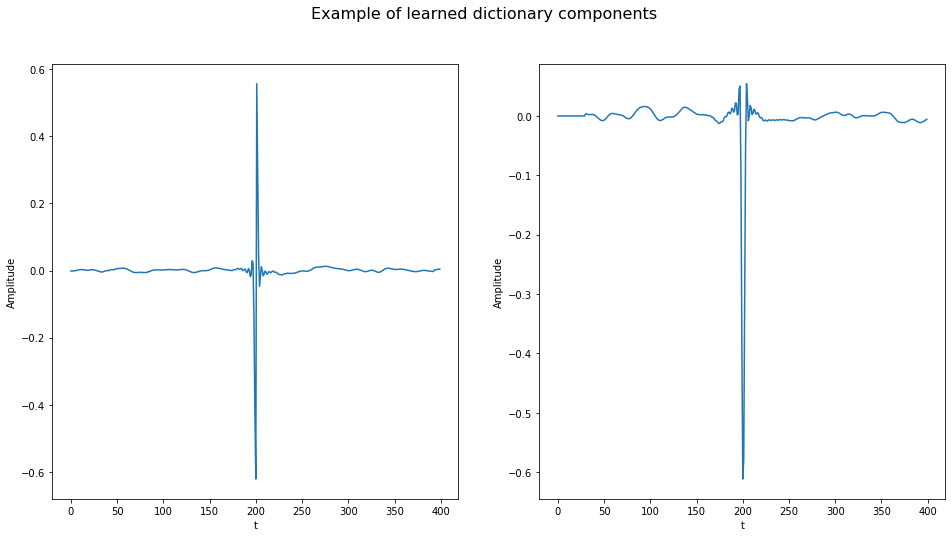

In [ ]:
#check last dictionary learned
fig, ax = plt.subplots(1,len(dicti.components_), figsize=(8*len(dicti.components_), 8))
for i in range(len(dicti.components_)):
  fig.suptitle("Example of learned dictionary components", fontsize=16)

  ax[i].plot(dicti.components_[i])
  ax[i].set_xlabel("t")
  ax[i].set_ylabel("Amplitude")

hopefully the dictionary learning algorithm will learn both a representative for the most frequent group of signals and will classify as anomalous the outliers of each group.

# 2) Results

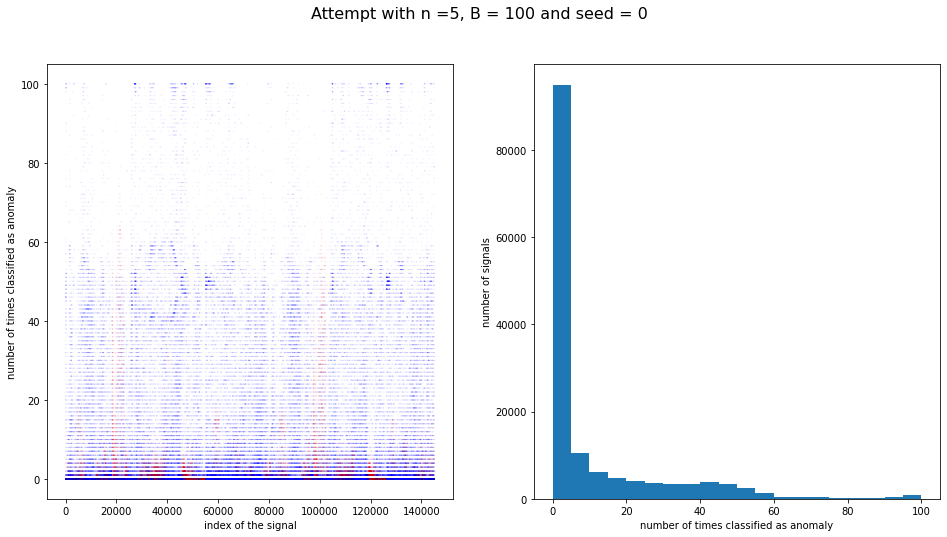

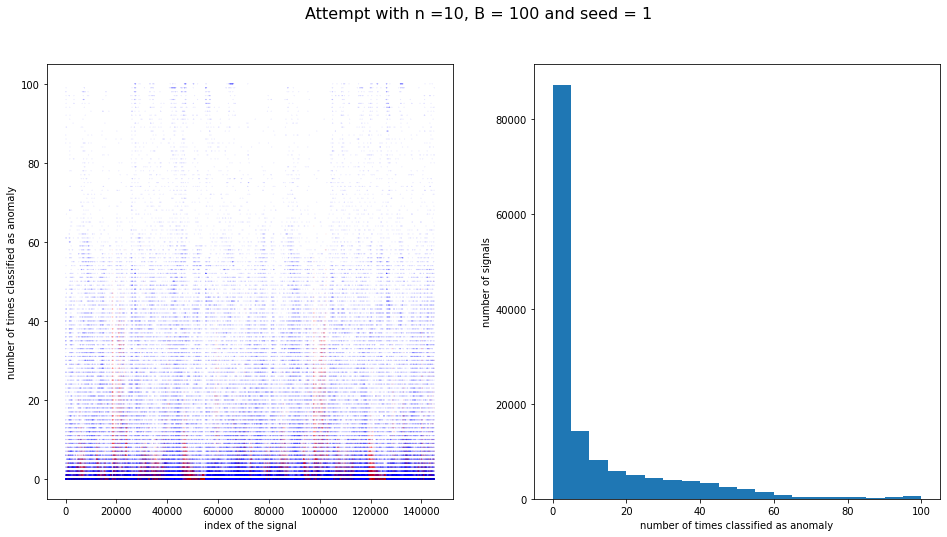

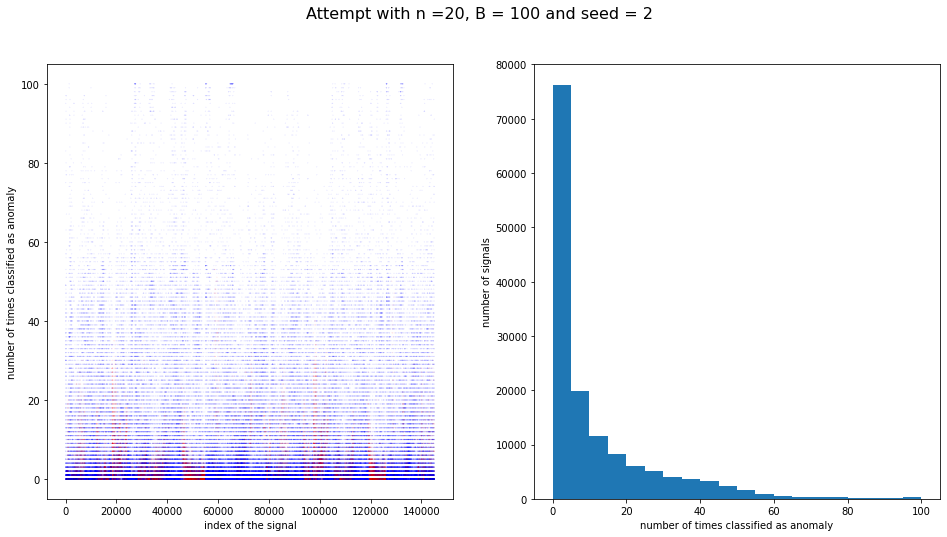

In [ ]:
col = ["blue"]*coordinates.shape[0]
col = np.array(col)
col[IIR > 1.22] = "red"

for i in range(len(ns)):

  fig, ax = plt.subplots(1,2, figsize=(16, 8))
  fig.suptitle("Attempt with n =" + str(ns[i]) + ", B = " +str(B[i]) + " and seed = " + str(seed[i]), fontsize=16)

  ax[0].scatter(np.arange(classification_matrix[i].shape[0]),classification_matrix[i].reshape(-1,), s = 0.001, c = col)
  ax[0].set_xlabel("index of the signal")
  ax[0].set_ylabel("number of times classified as anomaly")


  ax[1].hist(classification_matrix[i].reshape(-1,), bins = int(20))
  ax[1].set_xlabel("number of times classified as anomaly")
  ax[1].set_ylabel("number of signals")


There are few signals with IIR $\geq$ 1.22 classified as anomalous more than 20 times. 
This means that signals with this IIR are usually very closed together so our algorithm obtains different results from the IIR thrsholding clustering

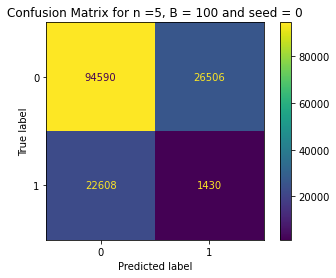

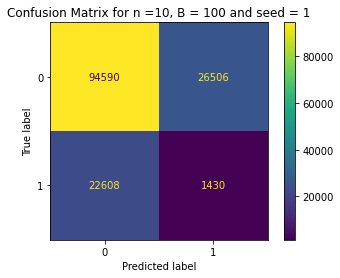

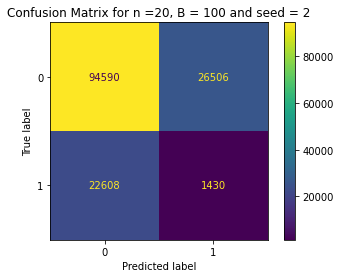

In [ ]:
for i in range(len(ns)): 
  final_labels = np.zeros(classification_matrix[i].shape)
  true_labels = np.zeros(classification_matrix[i].shape)
  true_labels[IIR>1.22] = 1
  final_labels = np.zeros(classification_matrix[i].shape)
  final_labels[(classification_matrix[0]>20)] = 1


  m = confusion_matrix(true_labels, final_labels)
  disp = ConfusionMatrixDisplay(m)
  disp.plot()
  disp.ax_.set_title("Confusion Matrix for n =" + str(ns[i]) + ", B = " +str(B[i]) + " and seed = " + str(seed[i]))


# 3) Conclusions
The method works well under the assumption of *isolated* and *rare* Anomalies. That is because the dictionary is trained to represent in a sparse way the majority of the signals of the group  and classifies as anomalous the badly represented ones, so that is why we need the latters to be spatially isolated and rare.

Comparing our results with the thresholding of IIR index we obtain different clusters. That is because signals spatially closed together have the same IIR
as we can see from the following plot and this is in contrast with our previous assumption of *isolated* anomalies.



/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


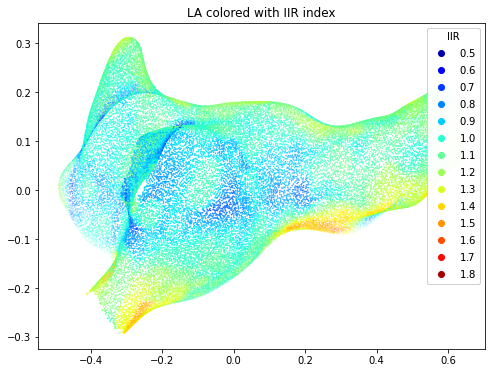

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

scatter = ax.scatter(coordinates[::2,0], coordinates[::2,1], coordinates[::2,2], c = IIR[::2], cmap="jet")
plt.title("LA colored with IIR index")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="IIR")
ax.add_artist(legend1)

# 4) Save the results

In [ ]:
# cd = "/gdrive/MyDrive/homework-pagani/hw4/final_project_SCT$AMM"
# filename = "/classification_matrix"
# now = datetime.now()
# filename+= str(now.strftime("%d_%m_%Y_%H-%M-%S"))
# np.save(cd + filename + "_dict_learning", classification_matrix)